In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Now it's time for another guided example. This time we're going to look at recipes. Specifically we'll use the epicurious dataset, which has a collection of recipes, key terms and ingredients, and their ratings.

What we want to see is if we can use the ingredient and keyword list to predict the rating. For someone writing a cookbook this could be really useful information that could help them choose which recipes to include because they're more likely to be enjoyed and therefore make the book more likely to be successful.

First let's load the dataset. It's [available on Kaggle](https://www.kaggle.com/hugodarwood/epirecipes). We'll use the csv file here and as pull out column names and some summary statistics for ratings.

In [2]:
raw_data = pd.read_csv('epi_r.csv')

In [3]:
list(raw_data.columns)

['title',
 'rating',
 'calories',
 'protein',
 'fat',
 'sodium',
 '#cakeweek',
 '#wasteless',
 '22-minute meals',
 '3-ingredient recipes',
 '30 days of groceries',
 'advance prep required',
 'alabama',
 'alaska',
 'alcoholic',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'anniversary',
 'anthony bourdain',
 'aperitif',
 'appetizer',
 'apple',
 'apple juice',
 'apricot',
 'arizona',
 'artichoke',
 'arugula',
 'asian pear',
 'asparagus',
 'aspen',
 'atlanta',
 'australia',
 'avocado',
 'back to school',
 'backyard bbq',
 'bacon',
 'bake',
 'banana',
 'barley',
 'basil',
 'bass',
 'bastille day',
 'bean',
 'beef',
 'beef rib',
 'beef shank',
 'beef tenderloin',
 'beer',
 'beet',
 'bell pepper',
 'berry',
 'beverly hills',
 'birthday',
 'biscuit',
 'bitters',
 'blackberry',
 'blender',
 'blue cheese',
 'blueberry',
 'boil',
 'bok choy',
 'bon appétit',
 'bon app��tit',
 'boston',
 'bourbon',
 'braise',
 'bran',
 'brandy',
 'bread',
 'breadcrumbs',
 'breakfast',
 'brie',
 'brine',
 'brisk

In [4]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

We learn a few things from this analysis. From a ratings perspective, there are just over 20,000 recipes with an average rating of 3.71. What is interesting is that the 25th percentile is actually above the mean. This means there is likely some kind of outlier population. This makes sense when we think about reviews: some bad recipes may have very few very low reviews.

Let's validate the idea a bit further with a histogram.

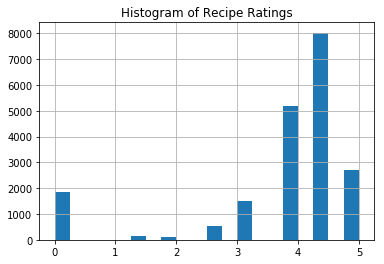

In [5]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

So a few things are shown in this histogram. Firstly there are sharp discontinutities. We don't have continuous data. No recipe has a 3.5 rating, for example. Also we see the anticipated increase at 0.

Let's try a naive approach again, this time using SVM Regressor. But first, we'll have to do a bit of data cleaning.

In [6]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

What we can see right away is that nutrition information is not available for all goods. Now this would be an interesting data point, but let's focus on ingredients and keywords right now. So we'll actually drop the whole columns for calories, protein, fat, and sodium. We'll come back to nutrition information later.

Firstly the overfit is a problem, even though it was poor in the first place. We could go back and clean up our feature set. There might be some gains to be made by getting rid of the noise.

We could also see how removing the nulls but including dietary information performs. Though its a slight change to the question we could still possibly get some improvements there.

Lastly, we could take our regression problem and turn it into a classifier. With this number of features and a discontinuous outcome, we might have better luck thinking of this as a classification problem. We could make it simpler still by instead of classifying on each possible value, group reviews to some decided high and low values.

__And that is your challenge.__

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

Good luck!


## My Code
To start, I will create a binary ratings variable where high ratings (greater than 4) have a value of 1 and low ratings (4 or lower) have a value of 0.

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

#creating binary ratings data and creating the target variable for SVR 
raw_data['rating_hl'] = raw_data.rating.map(lambda x: 1 if x>4 else 0)
Y = raw_data.rating_hl

### Features: Common Ingredients
Now, I want to narrow down the ingredients to the top 50 most used ingredients to see if just using common ingredients will allow us to predict if the ratings are high or low.

In [8]:
#identifying the top most used ingredients 
ingred_count = pd.DataFrame(raw_data.drop(['title', 'rating', 'calories', 'protein', 'fat', 'sodium'], 1).sum(), columns=['count'])
top_ingred_count = ingred_count.sort_values(by='count', ascending=False).head(30)
top_ingred = list(top_ingred_count.index)

#setting up columns for top 30 most used ingredients and splitting for train and test
X1 = raw_data[top_ingred]
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y, test_size=0.25)

#### SVC Kernels
To determine the best kernel to use for this model, I will cross validate with all kernel types to determine which provides the highest accuracy without overfitting.

In [9]:
#instantiating and fitting model with linear kernel
svc1_l = SVC(C=0.01, kernel='linear')
svc1_l.fit(X1_train, Y1_train)
print('R-squared from Linear Kernel: ', svc1_l.score(X1_train, Y1_train))
print('Cross Validation Scores: ', cross_val_score(svc1_l, X1_train, Y1_train, cv=5))

R-squared from Linear Kernel:  1.0
Cross Validation Scores:  [1. 1. 1. 1. 1.]


A R-squared value of 1!?! I assume this is due to overfitting. I will try other kernels to see how well they fit with the same data. 

In [10]:
#instantiating and fitting model with polynomial kernel
svc1_p = SVC(C=0.01, kernel='poly')
svc1_p.fit(X1_train, Y1_train)
print('R-squared from Polynomial Kernel: ', svc1_p.score(X1_train, Y1_train))
print('Cross Validation Scores: ', cross_val_score(svc1_p, X1_train, Y1_train, cv=5))

R-squared from Polynomial Kernel:  0.5357404082718266
Cross Validation Scores:  [0.53572615 0.53572615 0.53574992 0.53574992 0.53574992]


The variety of R-squared values in cross validation makes more sense for the data.  This is a pretty accurate model for this data. Continue to cross validate with other kernels, but this is a good start.

In [11]:
#instantiating and fitting model with radial basis function kernel
svc1_rbf = SVC(C=0.01, kernel='rbf')
svc1_rbf.fit(X1_train, Y1_train)
print('R-squared from RBF Kernel: ', svc1_rbf.score(X1_train, Y1_train))
print('Cross Validation Scores: ', cross_val_score(svc1_rbf, X1_train, Y1_train, cv=5))

R-squared from RBF Kernel:  1.0
Cross Validation Scores:  [1. 1. 1. 1. 1.]


Again with the R-squared value of 1. Keep looking.

In [12]:
#instantiating and fitting model with radial basis function kernel
svc1_sig = SVC(C=0.01, kernel='sigmoid')
svc1_sig.fit(X1_train, Y1_train)
print('R-squared from Sigmoid Kernel: ', svc1_sig.score(X1_train, Y1_train))
print('Cross Validation Scores: ', cross_val_score(svc1_sig, X1_train, Y1_train, cv=5))

R-squared from Sigmoid Kernel:  1.0
Cross Validation Scores:  [1. 1. 1. 1. 1.]


The only kernel that does not overfit the data is the polynomial kernel.  I will try this same cross validation strategy with features that are the ingredients from top-rated recipes.

### Features: Top-Rated Ingredients

In [13]:
#identifying the ingredients from top-rated recipes
top_rated = raw_data[raw_data['rating'] >= 4]
top_rated_count = pd.DataFrame(top_rated.drop(['title', 'rating', 'calories', 'protein', 'fat', 'sodium'], 1).sum())
top_rated_count = top_rated_count.sort_values(by=0, ascending=False).head(30)
top_rated_ingred = list(top_rated_count.index)

#setting up columns for the top-rated ingredients, and splitting into train and test groups
X2 = raw_data[top_rated_ingred]
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y, test_size=0.25)

In [14]:
#instantiating and fitting linear kernel
svc2_l = SVC(C=0.1, kernel='linear')
svc2_l.fit(X2_train, Y2_train)
print('R-squared from Linear Kernel: ', svc2_l.score(X2_train, Y2_train))
print('Cross Validation Scores: ', cross_val_score(svc2_l, X2_train, Y2_train, cv=5))

R-squared from Linear Kernel:  1.0
Cross Validation Scores:  [1. 1. 1. 1. 1.]


The linear kernel again overfits the data.  Try other kernels.

In [15]:
#instantiating and fitting polynomial kernel
svc2_poly = SVC(C=0.1, kernel='poly')
svc2_poly.fit(X2, Y)
print('R-squared from Polynomial Kernel: ', svc2_poly.score(X2_train, Y2_train))
print('Cross Validation Scores: ', cross_val_score(svc2_poly, X2_train, Y2_train, cv=5))

R-squared from Polynomial Kernel:  0.6941285989759958
Cross Validation Scores:  [0.61668883 0.62632979 0.62433511 0.63131649 0.62853342]


This model is less accurate than with the features from the most common ingredients, but cross validation is consistent across folds. 

In [16]:
#instantiating and fitting rbf kernel
svc2_rbf = SVC(C=0.1, kernel='rbf')
svc2_rbf.fit(X2, Y)
print('R-squared from RBF Kernel: ', svc2_rbf.score(X2_train, Y2_train))
print('Cross Validation Scores: ', cross_val_score(svc2_rbf, X2_train, Y2_train, cv=5))

R-squared from RBF Kernel:  1.0
Cross Validation Scores:  [1. 1. 1. 1. 1.]


Again the rbf kernel overfits the data with an R-squared value of 1. 

In [17]:
#instantiating and fitting sigmoid kernel
svc2_sig = SVC(C=0.1, kernel='sigmoid')
svc2_sig.fit(X2, Y)
print('R-squared from Sigmoid Kernel: ', svc2_sig.score(X2_train, Y2_train))
print('Cross Validation Scores: ', cross_val_score(svc2_sig, X2_train, Y2_train, cv=5))

R-squared from Sigmoid Kernel:  1.0
Cross Validation Scores:  [1. 1. 1. 1. 1.]


Based on the data, the best kernel for this classifier model is the polynomial kernel.  This provided an accuracy of around 60% using 30 ingredients from the top rated recipes.  We will now test the model's accuracy using the test data to determine how well the model predicts values. 

In [19]:
y2_pred_poly = svc2_poly.predict(X2_test)
crosstab = pd.crosstab(y2_pred_poly, Y2_test)
print('Crosstabulation: ', pd.crosstab(y2_pred_poly, Y2_test))
print('Accuracy of TEST set for SVC Poly Kernel: ', svc2_poly.score(X2_test, Y2_test))

Crosstabulation:  rating_hl     0     1
row_0                
0           811     0
1          1544  2658
Accuracy of TEST set for SVC Poly Kernel:  0.6920007979253939


In [23]:
print('Top-rated Ingredients: \n', X2.columns)

Top-rated Ingredients: 
 Index(['rating_hl', 'bon appétit', 'peanut free', 'soy free', 'tree nut free',
       'vegetarian', 'kosher', 'gourmet', 'pescatarian', 'quick & easy',
       'wheat/gluten-free', 'bake', 'summer', 'dessert', 'fall',
       'no sugar added', 'dairy free', 'winter', 'dinner', 'side',
       'sugar conscious', 'kidney friendly', 'healthy', 'onion', 'tomato',
       'fruit', 'milk/cream', 'sauté', 'vegetable', 'kid-friendly'],
      dtype='object')


The 30 ingredients that were present in recipes that were rated over 4 stars produced a support vector machine classification model with the highest accuracy when using the polynomial fit kernel. In using these ingredients, they are not only ingredients, but descriptions of types of recipes.   

When you've finished that, also take a moment to think about bias. Is there anything in this dataset that makes you think it could be biased, perhaps extremely so?

There is. Several things in fact, but most glaringly is that we don't actually have a random sample. It could be, and probably is, that the people more likely to choose some kinds of recipes are more likely to give high reviews.

After all, people who eat chocolate _might_ just be happier people.